In [30]:
import numpy as np
import pylab as py
import matplotlib.patches as mpatches
import os
## This is the base folder
os.chdir('/ga/amit/BIO/FINAL')
import sys
sys.path.append("CODE")
print(sys.path)
from utils import augment_background_thick, color_image, load_model,  get_file_numbers
from analyze_to_csv import process_files, analyze_p, match_points_from_ims
import torch
import pandas as pd
from PIL import Image
from predict import predict, predict_file
import re
import os
import shutil
gn='0'
device = torch.device("cuda:"+gn if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

['/ga/amit/BIO/FINAL', '/opt/anaconda3_new/lib/python312.zip', '/opt/anaconda3_new/lib/python3.12', '/opt/anaconda3_new/lib/python3.12/lib-dynload', '', '/home/amit/.local/lib/python3.12/site-packages', '/opt/anaconda3_new/lib/python3.12/site-packages', '/opt/anaconda3_new/lib/python3.12/site-packages/setuptools/_vendor', 'CODE', 'CODE', 'CODE', 'CODE']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### The two models we want to use: actin$\rightarrow$junction, pred_junction$\rightarrow$outline

In [298]:
model_a="mods_1/actin_junction_mix_0.1_kernel_5_nlayers_4_ds_100_lrstep_100_ws_200_fl_0_1"
model_o="mods_1/pred_junction_outline_mix_0.0_kernel_5_nlayers_4_ds_0_lrstep_100_ws_200_fl_0_bdy_10_mrg_40_1"

### Create folders with the predicted junctions and predicted outline images. 
## This is not essential and can be skipped for the following cells.

In [299]:
predict(device,model_a,None,x_prefix='actin',y_prefix='junction')
predict(device,model_o,model_a,x_prefix='pred_junction',y_prefix='outline')

### Analyze cells in predicted outline images and write to an excel file. Then add the information from the ground truth outline images.

In [19]:
target='test/'
dfp=analyze_p(device,model_a,model_o)
dfp.to_excel('try.xlsx')
fdgt=analyze_p(device,model_a,model_o, gt=True, dfp=dfp)
fdgt.to_excel('trygt.xlsx')

### Show predicted and true outlines and connect matching cells. Also show predicted and true junctions and original actin image.

In [295]:
def show_outline_new(k,ax,model_a,model_o,target,i,reduce=False):

    ima, imj, imo, imj_p, imo_p, celltype=process_files(device,i,model_a, model_o,target)  
    numim=4
    centt, centt_m, ctp, centp, JJ, cdp ,cdt = match_points_from_ims(i,imo_p, imo, ima, imj, celltype)

    imbb=np.concatenate((imo_p,imo),axis=1)

    imtaa=augment_background_thick(imo,10,40)
    
    ll=len(np.unique(imo_p))
    llt=len(np.unique(imo))
   
    imn=0
    
    ax[k,imn].imshow(color_image(imbb,reduce=reduce))
    ax[k,imn].plot([1053,1053],[0,1500],linewidth=2,color='black')
    ax[k,imn].set_title('Predicted outline          ground truth',fontsize=20)
    if centt is not None:
        ax[k,imn].scatter(centt[:,1]+1053,centt[:,0],s=100,color='cyan')
        if centp is not None:
            ax[k,imn].scatter(centp[:,1],centp[:,0],s=100,color='black')
        if len(ctp)>0:
            ax[k,imn].scatter(ctp[:,1],ctp[:,0],s=100,color='cyan')
            for ii in range(len(centt_m)):
                 ax[k,imn].plot([centt_m[ii,1]+1053,ctp[ii,1]],[centt_m[ii,0],ctp[ii,0]],linewidth=4,color='orange')
    
    ax[k,imn].xaxis.set_visible(False)  # Hide X-axis
    ax[k,imn].yaxis.set_visible(False)
    imn+=1
        
    
    #py.subplot(1,numim,imn)
    ax[k,imn].imshow(imj_p)
    ax[k,imn].axis('off')
    ax[k,imn].set_title('Predicted \n junctions',fontsize=20)
    #py.subplot(1,numim,imn)
    imn+=1
    ax[k,imn].imshow(imj)
    ax[k,imn].axis('off')
    ax[k,imn].set_title('Junctions',fontsize=20)
    #py.subplot(1,numim,imn)
    imn+=1
    ax[k,imn].imshow(ima)
    ax[k,imn].axis('off')
    ax[k,imn].set_title('Actin',fontsize=20)
    return JJ, cdp, cdt

#### Prepare a legend for boundary types

In [300]:
def get_legend_patches(reduce=False):
    
    colors = ['red', 'yellow','green']
    legend_patches = []
    if not reduce:
        labels = ['Junction', 'Thick', 'Broken']
        for color, label in zip(colors, labels):
            patch = mpatches.Patch(color=color, label=label)
            legend_patches.append(patch)
    else:
        colors = ['red','green']
        labels = ['Junction', 'Broken']
        for color, label in zip(colors,labels):
            patch = mpatches.Patch(color=color, label=label)
            legend_patches.append(patch)
    return legend_patches

### Show some predictions of outlines and compare to ground truth.

60 images
first image 10 number of images 2 reduced True
(1509, 1053)
(1509, 1053)


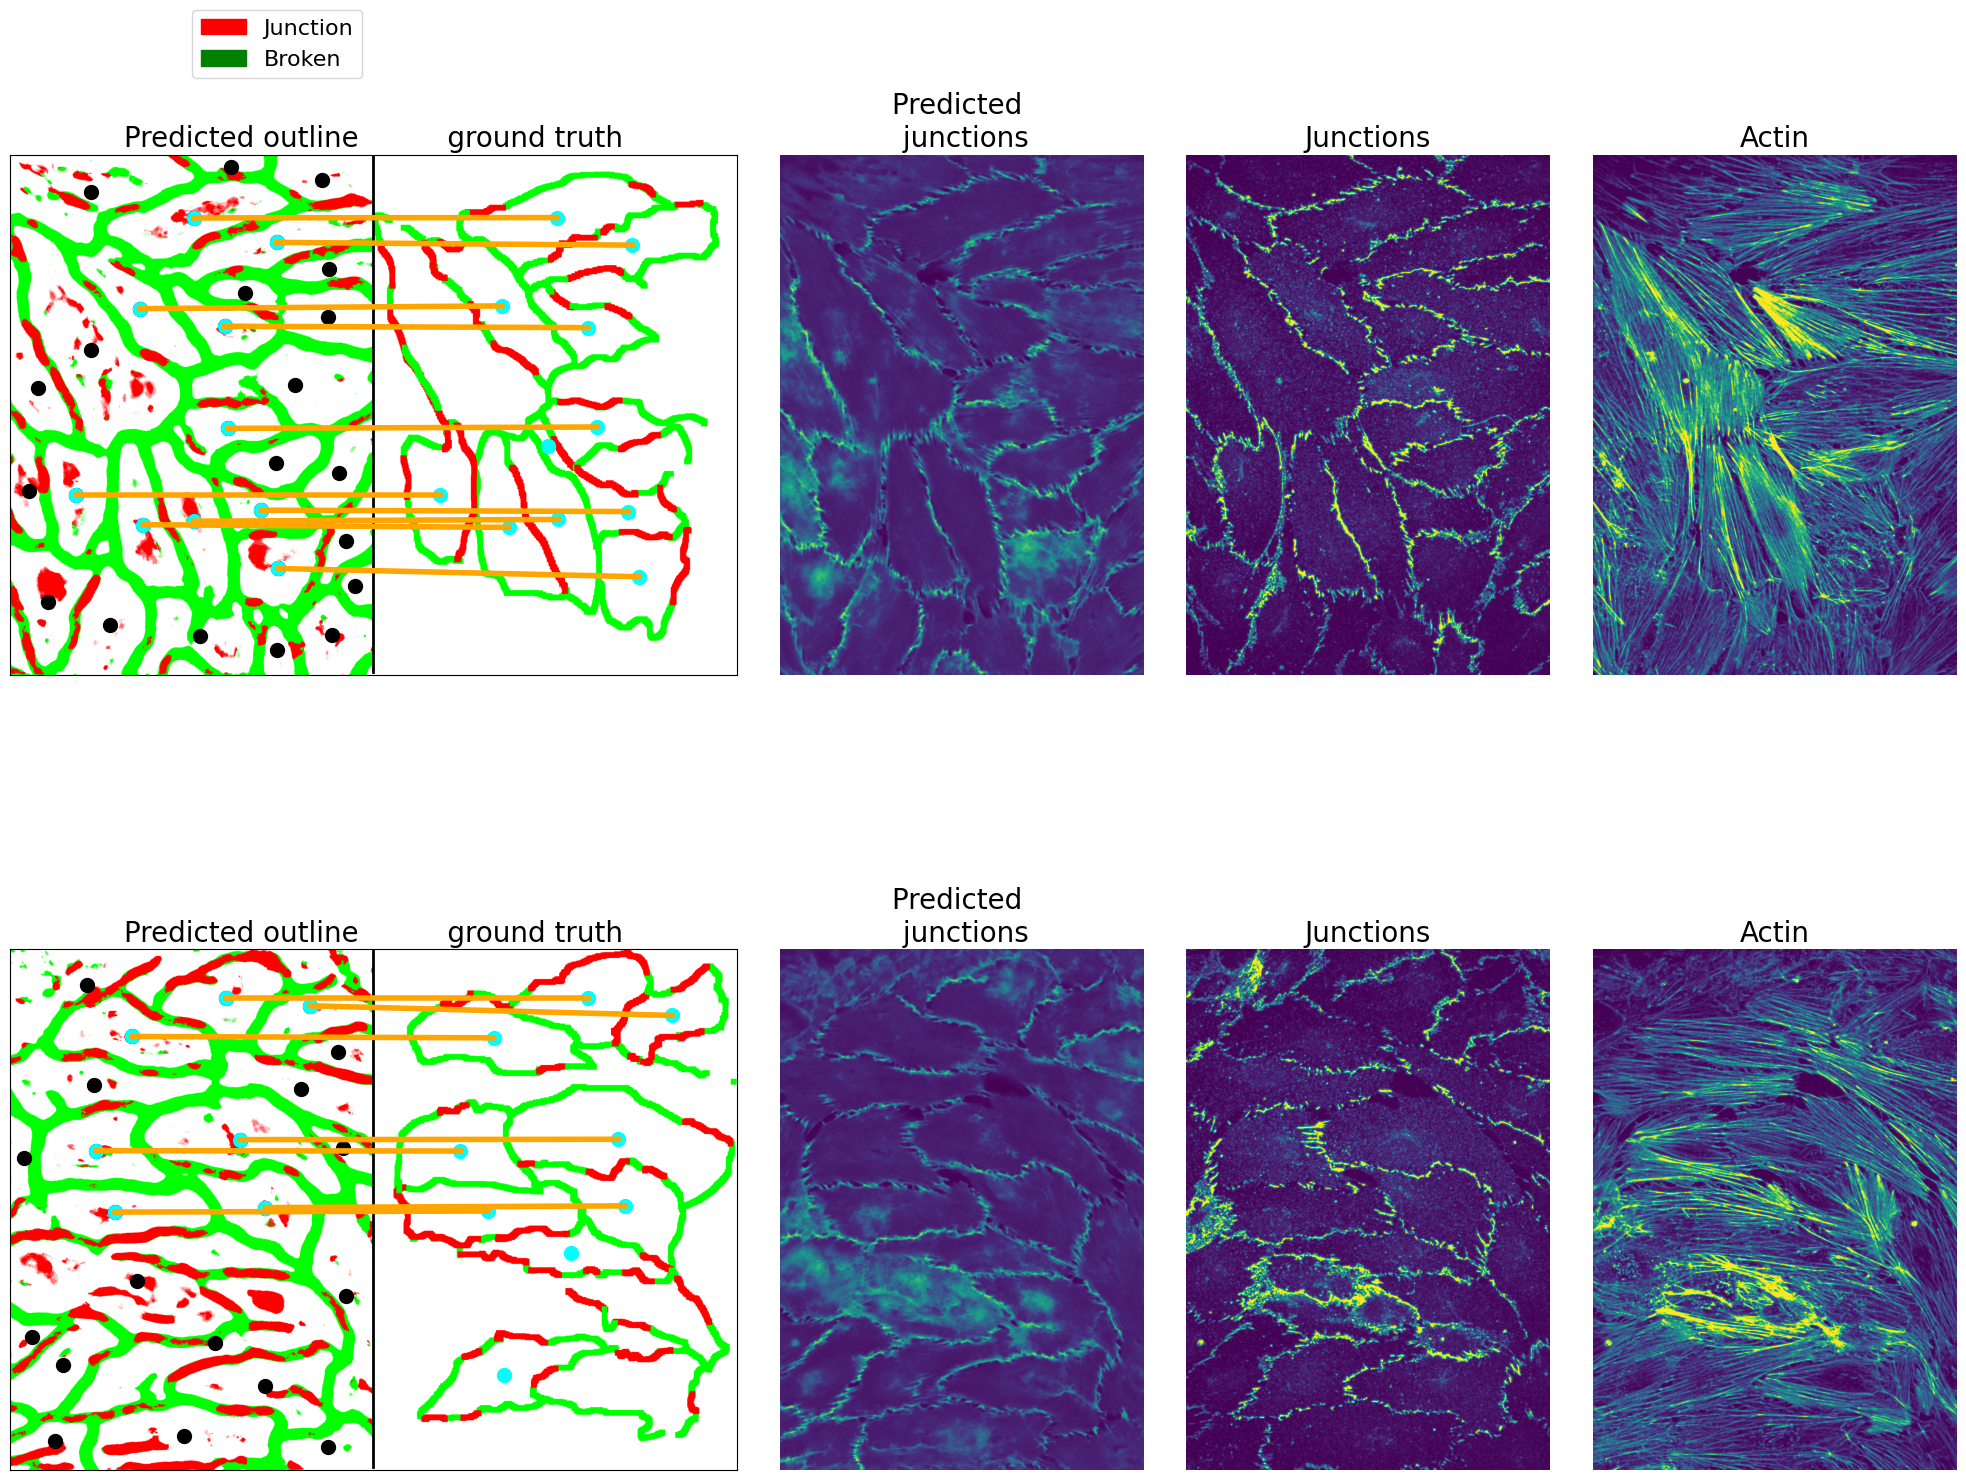

In [301]:
reduce=True
target='test/'
dira='data/'
ii=get_file_numbers(dira+target)
ii=np.unique(ii)
print(len(ii),'images')

nim=2 # Number of input images to process
first=10 # First input image to process
first=np.minimum(len(ii)-nim,first)
print('first image',first,'number of images',nim,'reduced',reduced)
legend_patches=get_legend_patches(reduce=reduce)

fig, ax=py.subplots(nim,4,figsize=(20,8*nim),gridspec_kw={'width_ratios': [2,1,1,1]})
ax=ax.reshape(nim,4)

fig.tight_layout()
ii=np.sort(ii)

for k,i in enumerate(ii[first:first+nr]):

    JJ, cdp, cdt= show_outline_new(k,ax,model_a,model_o,target,i,reduce=reduce)

ax[0,0].legend(handles=legend_patches,bbox_to_anchor=(0., 1.3, .5, 0),fontsize=16)

### Show leakiness and outlines predicted from junctions.

In [247]:
def compare_leakiness_outlines(numfigs,i,zero_thresh,model_name,model_name1,fig,tt='test/',indir='permeability/',reduce=False):
    py.rcParams.update({'font.size': 7})
    leak_thresh=0.1
    device="cuda:2"
    dir='data/'+indir
    if indir=='leak_outline/':
        x_prefix='junc'
        tt=''
        leak_name='perm'
    else:
        x_prefix='junction'
        leak_name='leakiness'

    pd=40
    im_leak_pred=predict_file(device,tt, model_name, i, 
                     x_prefix=x_prefix, y_prefix='leakiness', pad_size=pd, zero_thresh=zero_thresh)
    
    #img = Image.fromarray(im)
    #img.save('data/leak_outline/perm_pred'+str(zero_thresh)+'_'+str(i)+'.tif')
    nump=6
   
    imn=(i-1)*nump+1
    

    im=None
    if nump==6:
        im_pred=predict_file(device,tt, model_name1, i, 
                         x_prefix=x_prefix, y_prefix='outline', pad_size=pd, zero_thresh=zero_thresh)
        im_outline_pred=color_image(im_pred,reduce=reduce)
        ax=fig.add_subplot(numfigs,nump,imn)
        impb=im_outline_pred.copy()
        #impb[:,:,3]=1.
        py.imshow(impb) 
        ax = py.gca()
        ax.xaxis.set_visible(False)  # Hide X-axis
        ax.yaxis.set_visible(False)
        py.title('Outlines')
        imn+=1
    if i==1:
        legend_patches=get_legend_patches(reduce=reduce)
        ax.legend(handles=legend_patches,bbox_to_anchor=(1.1, 1.7, 0.3, 0.),fontsize=16)  
        
  
    im_leak_outline=np.ones((im_pred.shape[0],im_pred.shape[1],4))

    bdy=np.logical_or(im_pred==2,im_pred==1)
    broken=(im_pred==3)
    im_leak_outline[bdy,0]=1
    im_leak_outline[bdy,1]=0
    im_leak_outline[bdy,2]=0
    im_leak_outline[:,:,3]=.2
    #im_leak_outline[:,:,0]=im_leak_pred
    fig.add_subplot(numfigs,nump,imn)
    im_leak=im_leak_pred.copy()
    #im_leak[1-bdy]=0
    py.imshow((1-im_leak),cmap='gray',alpha=.5)
    py.imshow(im_leak_outline)
    py.title('Leakiness prediction \n on predicted linear+thick')
    ax = py.gca()
    ax.xaxis.set_visible(False)  # Hide X-axis
    ax.yaxis.set_visible(False)
    imn+=1

    im_leak_outline=np.zeros((im_pred.shape[0],im_pred.shape[1],4))
    im_leak_outline[broken,0]=0
    im_leak_outline[broken,1]=1
    im_leak_outline[broken,2]=0
    im_leak_outline[broken,3]=.2
    fig.add_subplot(numfigs,nump,imn)
    im_leak=im_leak_pred.copy()
    #im_leak[1-broken]=0
    py.imshow((1-im_leak)*.5,cmap='gray',alpha=.5)

    py.imshow(im_leak_outline)
    py.title('Leakiness prediction \n on predicted broken')
    ax = py.gca()
    ax.xaxis.set_visible(False)  # Hide X-axis
    ax.yaxis.set_visible(False)
    imn+=1

    
    imt=py.imread(dir+tt+leak_name+str(i)+'.tif')
    imt=imt/255.
    imtt=np.copy(imt)
    imtt[imtt<leak_thresh]=0
    fig.add_subplot(numfigs,nump,imn)
    loss=np.mean((imtt-im_leak_pred)**2)
    py.imshow(1.-imtt,cmap='gray')
    im_leak_outline=np.zeros((im_pred.shape[0],im_pred.shape[1],4))
    im_leak_outline[bdy,0]=1
    im_leak_outline[bdy,1]=0
    im_leak_outline[bdy,2]=0
    im_leak_outline[bdy,3]=.3
    py.imshow(im_leak_outline)
    pl=(f'leakiness with \n predicted linear+thick, {loss:,.3f}')
    py.title(pl)
    ax = py.gca()
    ax.xaxis.set_visible(False)  # Hide X-axis
    ax.yaxis.set_visible(False)
    imn=imn+1

    imt=py.imread(dir+tt+leak_name+str(i)+'.tif')
    imt=imt/255.
    imtt=np.copy(imt)
    imtt[imtt<leak_thresh]=0
    fig.add_subplot(numfigs,nump,imn)
    loss=np.mean((imtt-im_leak_pred)**2)
    py.imshow(1.-imtt,cmap='gray')
    im_leak_outline=np.zeros((im_pred.shape[0],im_pred.shape[1],4))
    im_leak_outline[broken,0]=0
    im_leak_outline[broken,1]=1
    im_leak_outline[broken,2]=0
    im_leak_outline[broken,3]=.3
    py.imshow(im_leak_outline)
    pl=(f'leakiness with \n predicted broken, {loss:,.3f}')
    py.title(pl)
    #py.axis('off')
    ax = py.gca()
    ax.xaxis.set_visible(False)  # Hide X-axis
    ax.yaxis.set_visible(False)
    imn=imn+1

    
    jfile=dir+tt+'/'+x_prefix+str(i)+'.tif'
    imja=py.imread(jfile)
    img = Image.fromarray(imja)
    #img.save('data/leak_outline/junc'+str(i)+'.tif')
    fig.add_subplot(numfigs,nump,imn)
    py.imshow(imja,cmap='gray')
    py.title('Junction')
    ax = py.gca()
    ax.xaxis.set_visible(False)  # Hide X-axis
    ax.yaxis.set_visible(False)
    
    #print(np.mean((imtl-im)*(imtl-im)))
    return(imt, imtl, im)

### Run the comparison on 10 images.

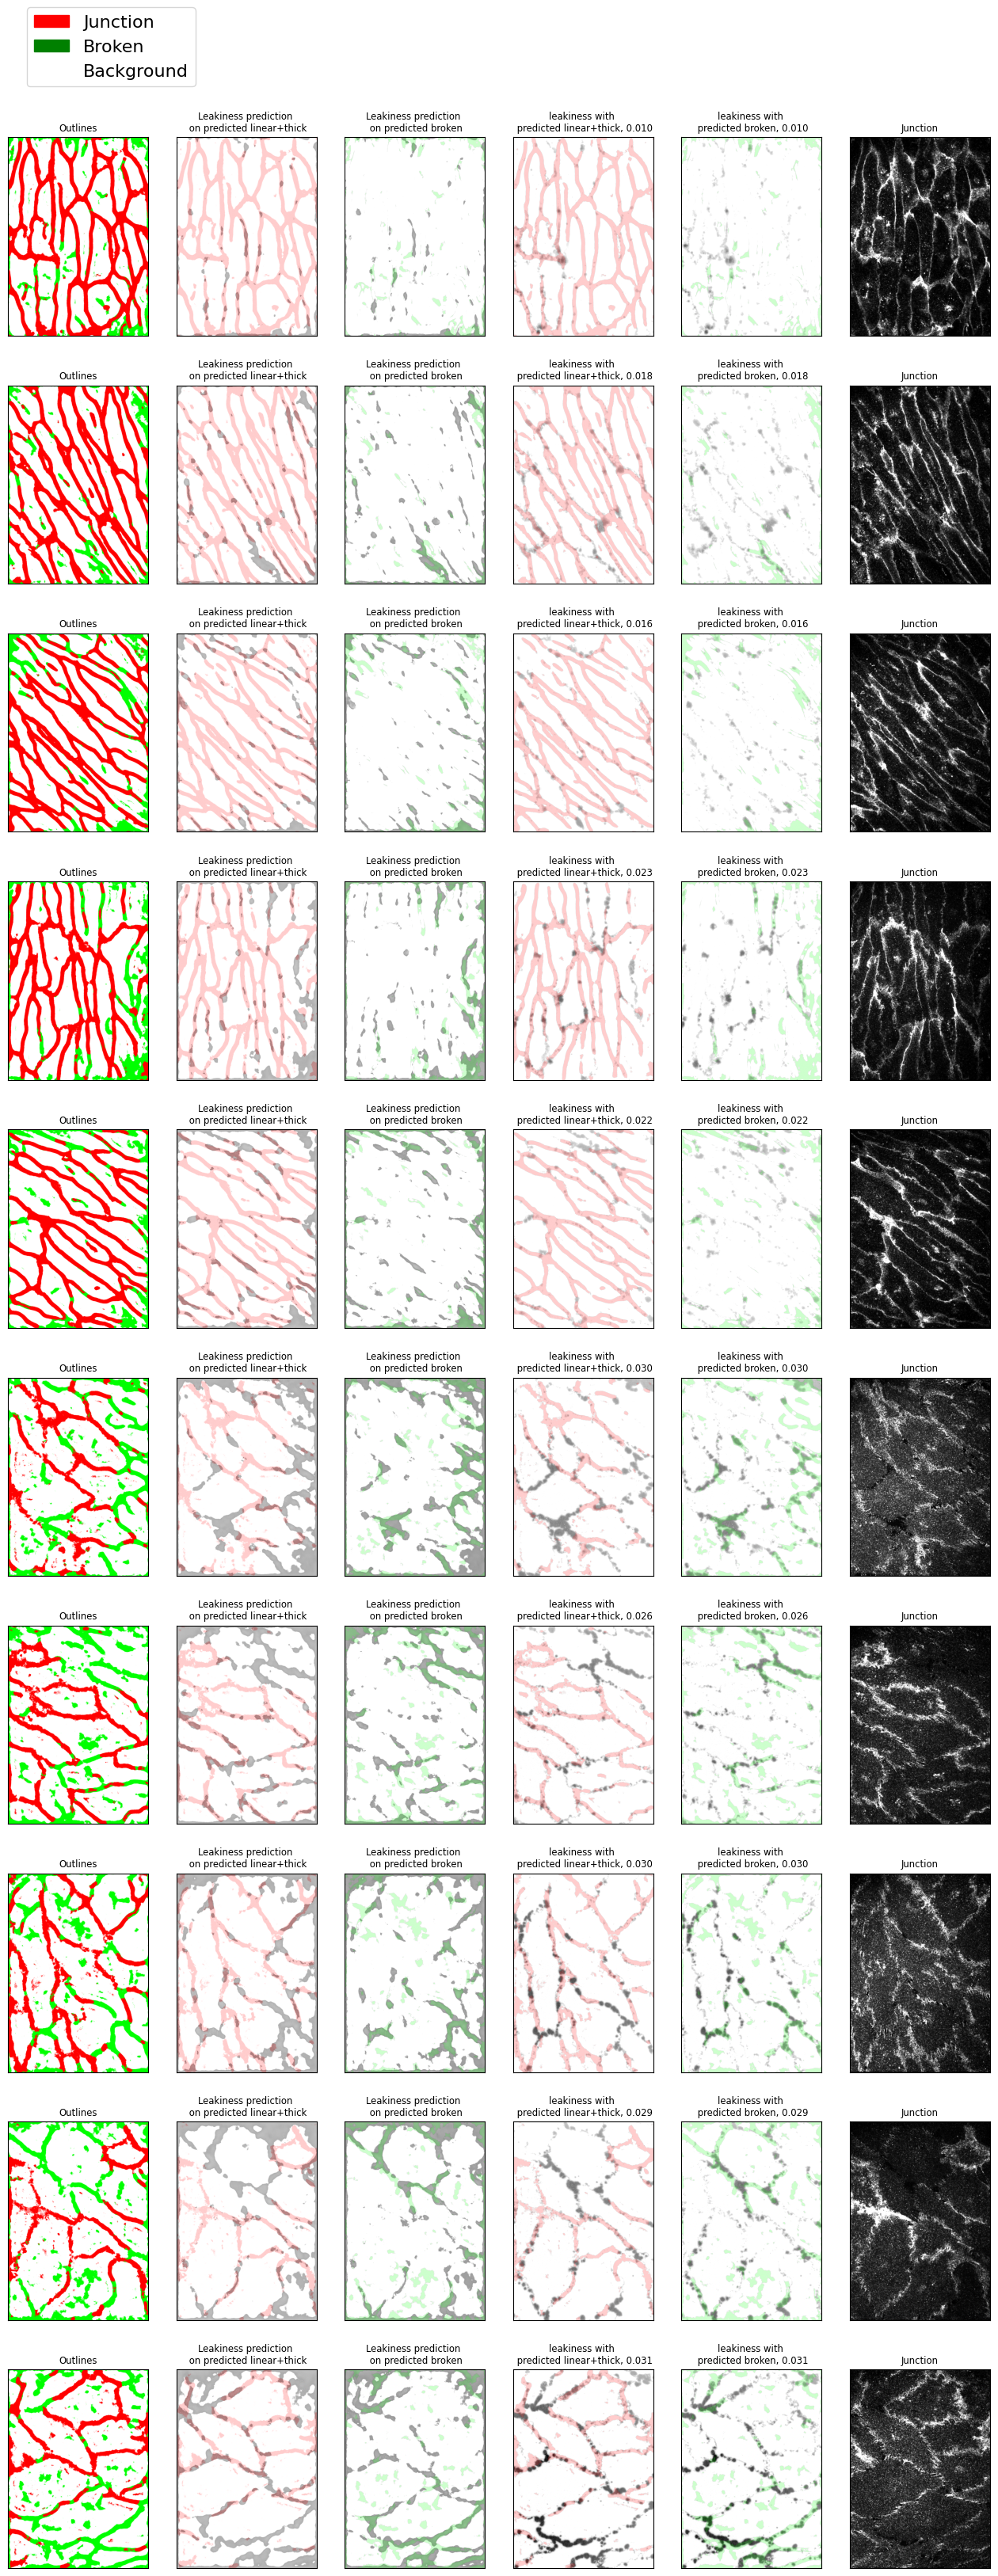

In [246]:
tt='test/'
model_name="mods_1/junction_leakiness_mix_1.0_ws_200_zero_weight_0.4_leak_thresh_0.1_fl_0_a_1.0_1"
model_name1='mods_1/junction_outline_mix_0.0_kernel_5_nlayers_4_ds_0_lrstep_100_ws_200_fl_0_bdy_10_mrg_40_1'
reduce=True
zero_thresh=0.8
fig=py.figure(figsize=(16,40))
for i in range(10):
    imt, imtl, im=compare_leakiness_outlines(10,i+1,zero_thresh,model_name,model_name1,fig,reduce=reduce)
    


### Show leakiness predictions with different thresholds for background (out of 1.)

In [236]:
def compare_outputs_threshes(numfigs,i,zero_thresh,model_name,tt,fig):
    py.rcParams.update({'font.size': 7})
    leak_thresh=0.1
    device="cuda:2"
    dir='data/permeability/'
    pd=40
    nump=5
    imt=py.imread(dir+tt+'/leakiness'+str(i)+'.tif')
    imt=imt/255.
    for j,z in enumerate(zero_thresh):
        im=predict_file(device,tt, model_name, i, 
                     x_prefix='junction', y_prefix='leakiness', pad_size=pd, zero_thresh=z)    
        imn=(i-1)*nump+j+1
        fig.add_subplot(numfigs,nump,imn)
        imn+=1
        py.imshow(1-im,cmap='gray')
        ax = py.gca()
        ax.xaxis.set_visible(False)  # Hide X-axis
        ax.yaxis.set_visible(False)

        loss=np.mean((imt-im)**2)
        pl=(f'Pred, thresh {z:,.2f}, loss {loss:,.3f}')
        py.title(pl)

    
    
    fig.add_subplot(numfigs,nump,imn)
    imn+=1
    
    
    py.imshow(1-imt,cmap='gray')
    #py.imshow(imp)
    py.title('Leakiness')
    py.axis('off')
    
    jfile=dir+tt+'/junction'+str(i)+'.tif'
    imja=py.imread(jfile)
    fig.add_subplot(numfigs,nump,imn)
    py.imshow(imja,cmap='gray')
    py.title('Junction')
    py.axis('off')
    
    #print(np.mean((imtl-im)*(imtl-im)))
    return(imt, imtl, im)

### Run the comparison on 10 images.

In [ ]:
tt='test/'

zero_thresh=(0.5,0.65,0.8)
fig=py.figure(figsize=(16,40))
for i in range(10):
    imt, imtl, im=compare_outputs_threshes(10,i+1,zero_thresh,model_name,tt,fig)
py.savefig('Leak_with_threshes.png')